In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_env = "local"

if current_env == "local":
    data_path = "../ump-dataset"

elif current_env == "kaggle":
    data_path = "../input/ump-dataset"
    
elif current_env == "colab":
    pass

print("data_path:", data_path)

data_path: ../ump-dataset


***
## loading data

In [3]:
features = [f"f_{i}" for i in range(300)]

features = pd.read_parquet(f"{data_path}/train.parquet", columns=features)
display(features)

target = pd.read_parquet(f"{data_path}/train.parquet", columns=["target",])
display(target)

time = pd.read_parquet(f"{data_path}/train.parquet", columns=["time_id",])
display(time)

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,1.230508,0.114809,-2.012777,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,1.134144,0.114809,-0.219201,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,-1.125681,0.114809,-1.035376,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,0.298990,0.114809,-1.176410,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,1.230508,0.114809,-0.005858,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141405,0.093530,-0.720275,-0.345497,-0.438781,-0.166972,-0.437182,1.475746,1.284423,0.056425,-1.433681,...,-0.285908,-1.232434,-0.660579,0.875537,0.421628,-0.428097,-0.075548,-0.533092,-0.193732,-0.581394
3141406,-1.344935,-0.199987,-0.107702,-0.454677,-0.221914,-0.141174,-1.498235,1.373834,0.056425,-1.211572,...,0.184517,-1.232434,-0.670493,0.875537,0.421628,-0.729949,-1.514277,0.013145,-0.890270,-0.589705
3141407,0.979489,-1.110491,1.006980,-0.467307,-0.159549,1.355671,0.150812,-0.088923,0.056425,0.996380,...,-0.756332,-1.232434,0.820784,-1.142157,0.421628,-0.363329,1.363181,-0.079106,-1.580124,-0.297625
3141408,-2.565332,0.320301,0.076600,1.380182,-0.155366,-0.689000,0.381069,-1.324759,0.056425,-1.111730,...,-0.756332,-1.232434,0.133074,-1.142157,0.421628,-0.375288,-1.514277,-0.973762,0.608647,-0.372040


,target
0,-0.300875
1,-0.231040
2,0.568807
3,-1.064780
4,-0.531940
...,...
3141405,0.033600
3141406,-0.223264
3141407,-0.559415
3141408,0.009599


,time_id
0,0
1,0
2,0
3,0
4,0
...,...
3141405,1219
3141406,1219
3141407,1219
3141408,1219


In [4]:
time_ids = np.sort(time.time_id.unique())
len(time_ids)

1211

In [5]:
n_time_steps = len(time_ids)
print("time steps:", n_time_steps)

valid_prop = 0.1
valid_size = int(0.1 * n_time_steps)
print("valid size:", valid_size)

time steps: 1211
valid size: 121


In [6]:
# train-valid splits
n_splits = 3
end_idx = n_time_steps 

splits = list()

for start_idx in np.arange(1211, 0, -valid_size)[1:n_splits+1]:
    valid_time_ids = time_ids[start_idx:end_idx]
    train_time_end = time_ids[start_idx]-1
    end_idx = start_idx
    
    train_idx = time.query("time_id <= @train_time_end").index
    valid_idx = time.query("time_id in @valid_time_ids").index
    splits.append((train_idx,valid_idx))

In [7]:
import gc
gc.collect()

153

***
## model training: evaluation

In [8]:
def pearsonr(preds: np.array, dset: lgb.Dataset):
    """
    Helper function to compute Pearson correlation 
    on validation dataset for LightGBM as tracking metric.
    Args:
        preds: 1d-array with the model predictions
        dset: LightGBM dataset with the labels
    Returs:
        Tuple with the corresponding output
    """
    labels = dset.get_label()
    return 'pearsonr', stats.pearsonr(preds, labels)[0], True

In [9]:
model_params = {
    'boosting': 'dart',
    'objective': 'mse',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 128,
    'max_bin': 511,
    'force_col_wise': True,
    'bagging_freq': 1,
    'seed': 19,
    'verbosity': -1,
    'first_metric_only': False,
    'bin_construct_sample_cnt': 100000000,
    'feature_pre_filter': False,
    'bagging_fraction': 0.9,
    'drop_rate': 0.09,
    'feature_fraction': 0.35,
    'lambda_l1': 1.1127423904283282,
    'lambda_l2': 0.0017447397071228327,
    'max_drop': 90,
    'min_data_in_leaf': 2200,
    'num_iterations': 1900,
    'path_smooth': 7.961233039539337,
    'skip_drop': 0.55
}

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.897399	valid_0's pearsonr: 0.128899


[100]	valid_0's rmse: 0.896802	valid_0's pearsonr: 0.130263


[150]	valid_0's rmse: 0.896074	valid_0's pearsonr: 0.132458


[200]	valid_0's rmse: 0.895683	valid_0's pearsonr: 0.134411


[250]	valid_0's rmse: 0.895402	valid_0's pearsonr: 0.135548


[300]	valid_0's rmse: 0.895097	valid_0's pearsonr: 0.137283


[350]	valid_0's rmse: 0.895045	valid_0's pearsonr: 0.137607


[400]	valid_0's rmse: 0.894894	valid_0's pearsonr: 0.138512


[450]	valid_0's rmse: 0.894828	valid_0's pearsonr: 0.138054


[500]	valid_0's rmse: 0.89466	valid_0's pearsonr: 0.138956


[550]	valid_0's rmse: 0.894513	valid_0's pearsonr: 0.139812


[600]	valid_0's rmse: 0.894396	valid_0's pearsonr: 0.140757


[650]	valid_0's rmse: 0.894282	valid_0's pearsonr: 0.141772


[700]	valid_0's rmse: 0.894254	valid_0's pearsonr: 0.141393


[750]	valid_0's rmse: 0.894209	valid_0's pearsonr: 0.141702


[800]	valid_0's rmse: 0.894161	valid_0's pearsonr: 0.14197


[850]	valid_0's rmse: 0.894149	valid_0's pearsonr: 0.141949


[900]	valid_0's rmse: 0.894092	valid_0's pearsonr: 0.142308


[950]	valid_0's rmse: 0.894122	valid_0's pearsonr: 0.141988


[1000]	valid_0's rmse: 0.894105	valid_0's pearsonr: 0.14208


[1050]	valid_0's rmse: 0.894065	valid_0's pearsonr: 0.142314


[1100]	valid_0's rmse: 0.894059	valid_0's pearsonr: 0.142362


[1150]	valid_0's rmse: 0.893988	valid_0's pearsonr: 0.142898


[1200]	valid_0's rmse: 0.89396	valid_0's pearsonr: 0.143078


[1250]	valid_0's rmse: 0.893931	valid_0's pearsonr: 0.143295


[1300]	valid_0's rmse: 0.893905	valid_0's pearsonr: 0.143492


[1350]	valid_0's rmse: 0.893944	valid_0's pearsonr: 0.143213


[1400]	valid_0's rmse: 0.893905	valid_0's pearsonr: 0.143513


[1450]	valid_0's rmse: 0.893846	valid_0's pearsonr: 0.143992


[1500]	valid_0's rmse: 0.893819	valid_0's pearsonr: 0.144239


[1550]	valid_0's rmse: 0.89376	valid_0's pearsonr: 0.144725


[1600]	valid_0's rmse: 0.89373	valid_0's pearsonr: 0.144935


[1650]	valid_0's rmse: 0.893711	valid_0's pearsonr: 0.145153


[1700]	valid_0's rmse: 0.893746	valid_0's pearsonr: 0.144919


[1750]	valid_0's rmse: 0.893738	valid_0's pearsonr: 0.145024


[1800]	valid_0's rmse: 0.893733	valid_0's pearsonr: 0.145152


[1850]	valid_0's rmse: 0.893689	valid_0's pearsonr: 0.145547


[1900]	valid_0's rmse: 0.893741	valid_0's pearsonr: 0.1452


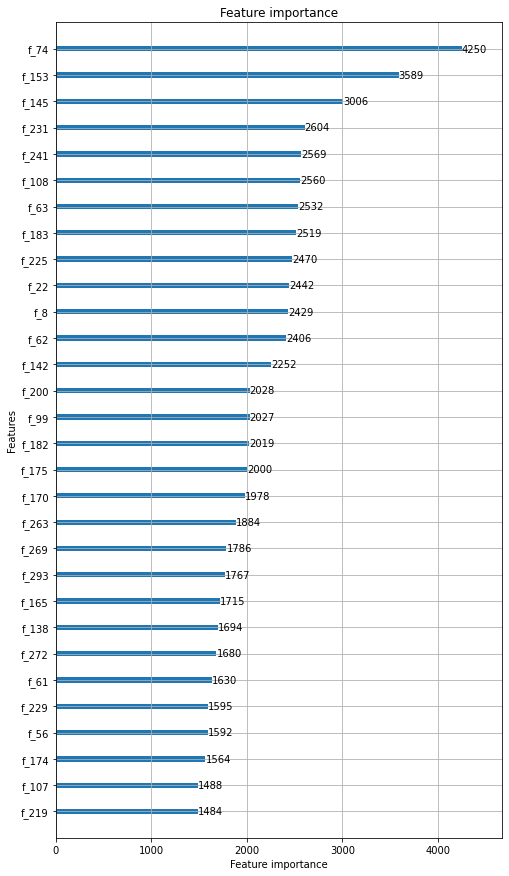

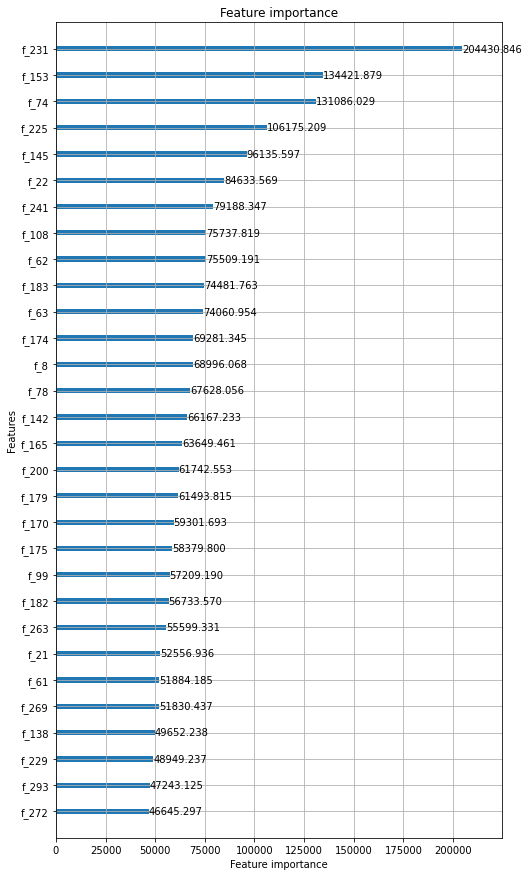

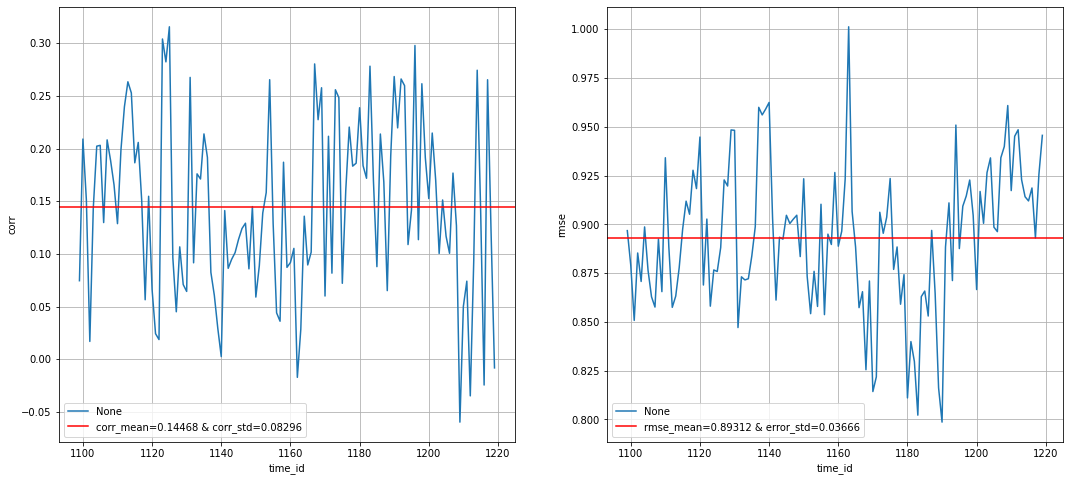

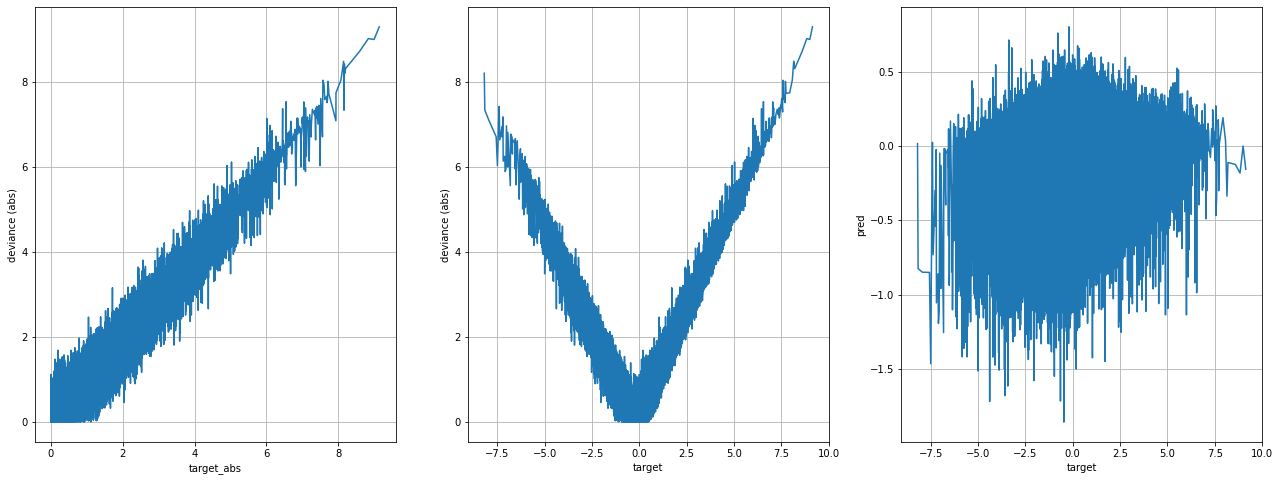

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.905005	valid_0's pearsonr: 0.119647


[100]	valid_0's rmse: 0.904171	valid_0's pearsonr: 0.125372


[150]	valid_0's rmse: 0.903259	valid_0's pearsonr: 0.130125


[200]	valid_0's rmse: 0.902758	valid_0's pearsonr: 0.133911


[250]	valid_0's rmse: 0.902313	valid_0's pearsonr: 0.136863


[300]	valid_0's rmse: 0.901997	valid_0's pearsonr: 0.138496


[350]	valid_0's rmse: 0.901852	valid_0's pearsonr: 0.139693


[400]	valid_0's rmse: 0.901726	valid_0's pearsonr: 0.140445


[450]	valid_0's rmse: 0.901409	valid_0's pearsonr: 0.141777


[500]	valid_0's rmse: 0.901212	valid_0's pearsonr: 0.142467


[550]	valid_0's rmse: 0.901103	valid_0's pearsonr: 0.142878


[600]	valid_0's rmse: 0.901037	valid_0's pearsonr: 0.143224


[650]	valid_0's rmse: 0.900997	valid_0's pearsonr: 0.143602


[700]	valid_0's rmse: 0.900831	valid_0's pearsonr: 0.144166


[750]	valid_0's rmse: 0.900802	valid_0's pearsonr: 0.144355


[800]	valid_0's rmse: 0.900793	valid_0's pearsonr: 0.14424


[850]	valid_0's rmse: 0.900697	valid_0's pearsonr: 0.144869


[900]	valid_0's rmse: 0.900645	valid_0's pearsonr: 0.145143


[950]	valid_0's rmse: 0.900684	valid_0's pearsonr: 0.144626


[1000]	valid_0's rmse: 0.900641	valid_0's pearsonr: 0.144856


[1050]	valid_0's rmse: 0.900625	valid_0's pearsonr: 0.144834


[1100]	valid_0's rmse: 0.900637	valid_0's pearsonr: 0.144736


[1150]	valid_0's rmse: 0.900653	valid_0's pearsonr: 0.14457


[1200]	valid_0's rmse: 0.900651	valid_0's pearsonr: 0.144529


[1250]	valid_0's rmse: 0.900681	valid_0's pearsonr: 0.144204


[1300]	valid_0's rmse: 0.900711	valid_0's pearsonr: 0.143953


[1350]	valid_0's rmse: 0.900745	valid_0's pearsonr: 0.143664


[1400]	valid_0's rmse: 0.90072	valid_0's pearsonr: 0.14384


[1450]	valid_0's rmse: 0.900747	valid_0's pearsonr: 0.14367


[1500]	valid_0's rmse: 0.900778	valid_0's pearsonr: 0.143492


[1550]	valid_0's rmse: 0.900829	valid_0's pearsonr: 0.143165


[1600]	valid_0's rmse: 0.900823	valid_0's pearsonr: 0.143203


[1650]	valid_0's rmse: 0.900786	valid_0's pearsonr: 0.143555


[1700]	valid_0's rmse: 0.900852	valid_0's pearsonr: 0.143082


[1750]	valid_0's rmse: 0.900832	valid_0's pearsonr: 0.143271


[1800]	valid_0's rmse: 0.900806	valid_0's pearsonr: 0.143547


[1850]	valid_0's rmse: 0.900868	valid_0's pearsonr: 0.143222


[1900]	valid_0's rmse: 0.900871	valid_0's pearsonr: 0.143201


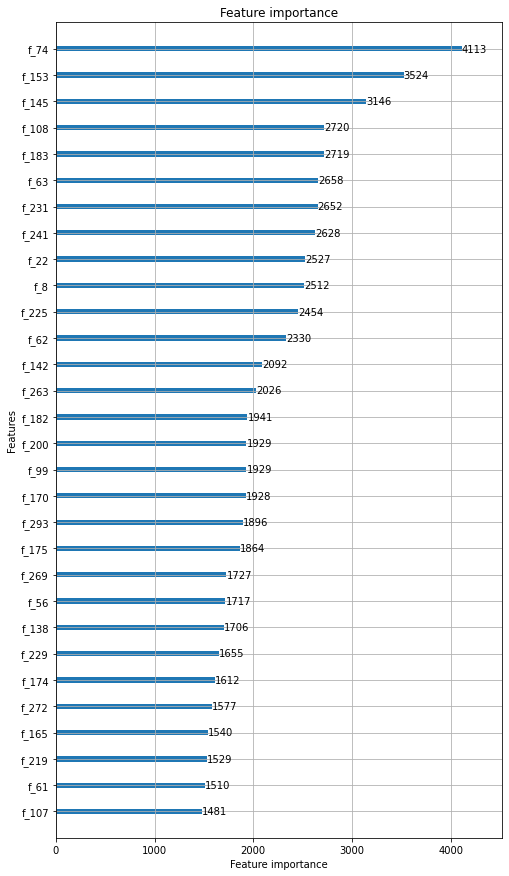

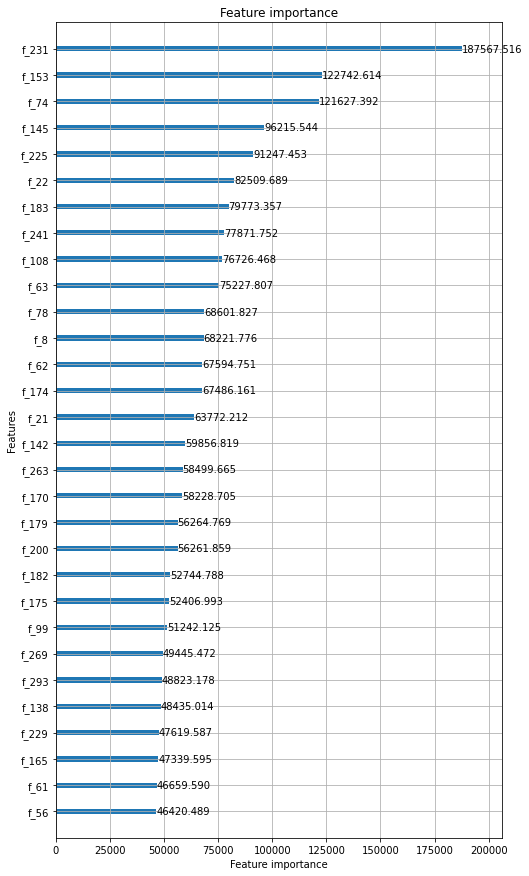

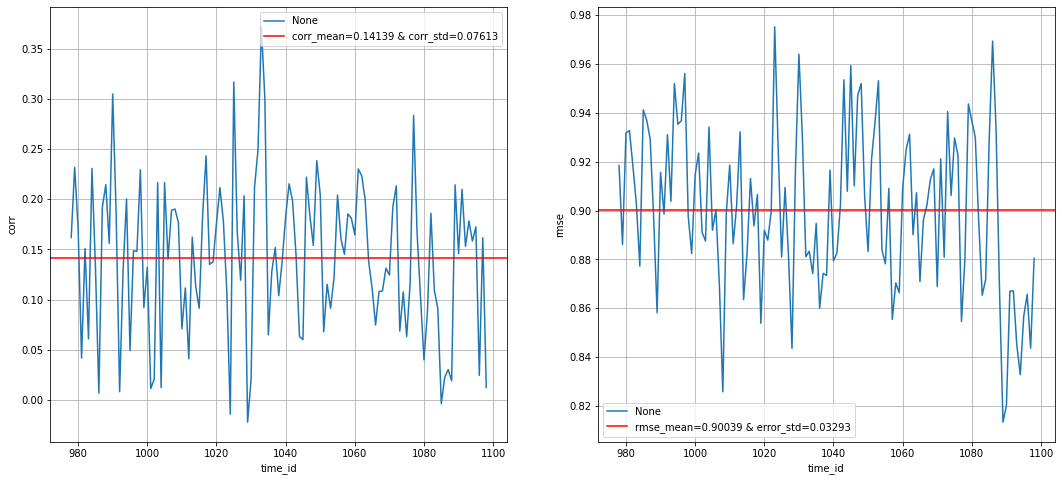

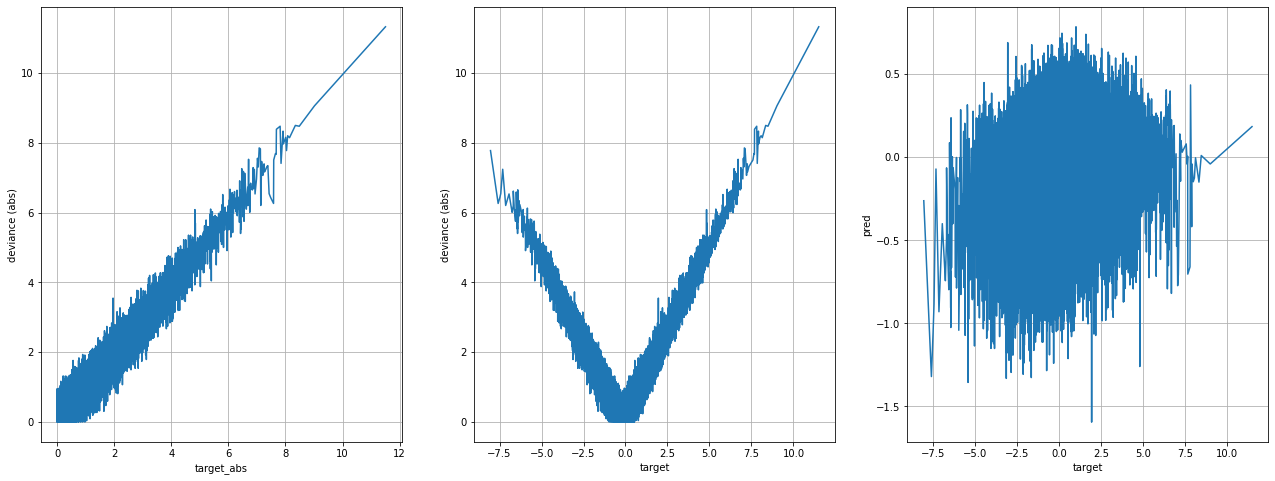

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's rmse: 0.939382	valid_0's pearsonr: 0.104005


[100]	valid_0's rmse: 0.938682	valid_0's pearsonr: 0.109604


[150]	valid_0's rmse: 0.937833	valid_0's pearsonr: 0.115906


[200]	valid_0's rmse: 0.937355	valid_0's pearsonr: 0.120176


[250]	valid_0's rmse: 0.936902	valid_0's pearsonr: 0.123639


[300]	valid_0's rmse: 0.936594	valid_0's pearsonr: 0.125608


[350]	valid_0's rmse: 0.936446	valid_0's pearsonr: 0.126943


[400]	valid_0's rmse: 0.936329	valid_0's pearsonr: 0.127842


[450]	valid_0's rmse: 0.936035	valid_0's pearsonr: 0.129577


[500]	valid_0's rmse: 0.935706	valid_0's pearsonr: 0.131944


[550]	valid_0's rmse: 0.935534	valid_0's pearsonr: 0.133062


[600]	valid_0's rmse: 0.935344	valid_0's pearsonr: 0.134599


[650]	valid_0's rmse: 0.935253	valid_0's pearsonr: 0.13544


[700]	valid_0's rmse: 0.935173	valid_0's pearsonr: 0.13566


[750]	valid_0's rmse: 0.935079	valid_0's pearsonr: 0.136394


[800]	valid_0's rmse: 0.934982	valid_0's pearsonr: 0.137113


[850]	valid_0's rmse: 0.934836	valid_0's pearsonr: 0.138183


[900]	valid_0's rmse: 0.934755	valid_0's pearsonr: 0.138725


[950]	valid_0's rmse: 0.934619	valid_0's pearsonr: 0.13972


[1000]	valid_0's rmse: 0.934517	valid_0's pearsonr: 0.140492


[1050]	valid_0's rmse: 0.934591	valid_0's pearsonr: 0.139818


[1100]	valid_0's rmse: 0.934581	valid_0's pearsonr: 0.139867


[1150]	valid_0's rmse: 0.934593	valid_0's pearsonr: 0.139761


[1200]	valid_0's rmse: 0.934528	valid_0's pearsonr: 0.14021


[1250]	valid_0's rmse: 0.934483	valid_0's pearsonr: 0.140535


[1300]	valid_0's rmse: 0.934391	valid_0's pearsonr: 0.141222


[1350]	valid_0's rmse: 0.934294	valid_0's pearsonr: 0.14196


[1400]	valid_0's rmse: 0.934234	valid_0's pearsonr: 0.142399


[1450]	valid_0's rmse: 0.934187	valid_0's pearsonr: 0.142762


[1500]	valid_0's rmse: 0.934112	valid_0's pearsonr: 0.14334


[1550]	valid_0's rmse: 0.934089	valid_0's pearsonr: 0.143575


[1600]	valid_0's rmse: 0.93409	valid_0's pearsonr: 0.143568


[1650]	valid_0's rmse: 0.934041	valid_0's pearsonr: 0.143983


[1700]	valid_0's rmse: 0.934052	valid_0's pearsonr: 0.143953


[1750]	valid_0's rmse: 0.934062	valid_0's pearsonr: 0.143933


[1800]	valid_0's rmse: 0.934025	valid_0's pearsonr: 0.144278


[1850]	valid_0's rmse: 0.933997	valid_0's pearsonr: 0.144559


[1900]	valid_0's rmse: 0.934023	valid_0's pearsonr: 0.144386


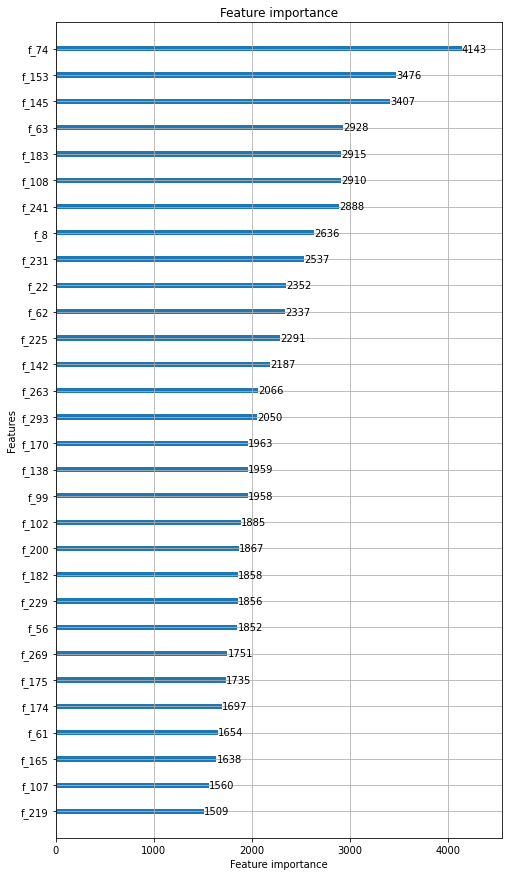

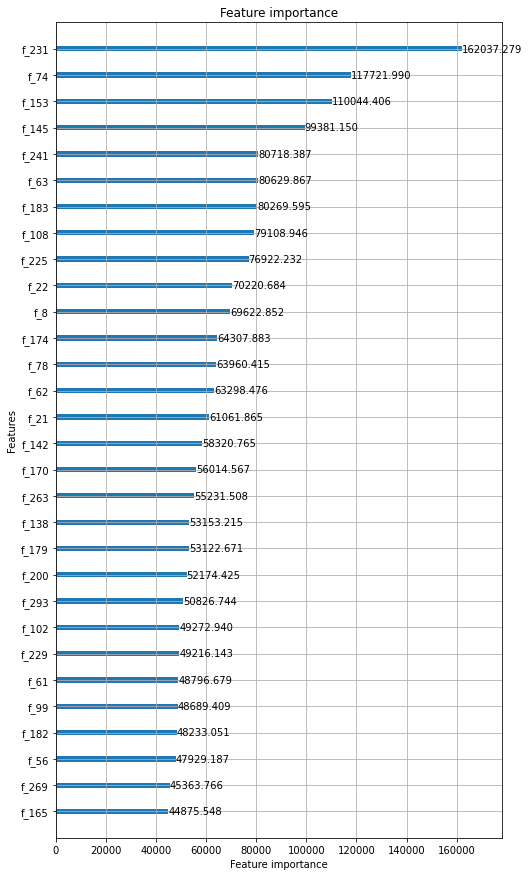

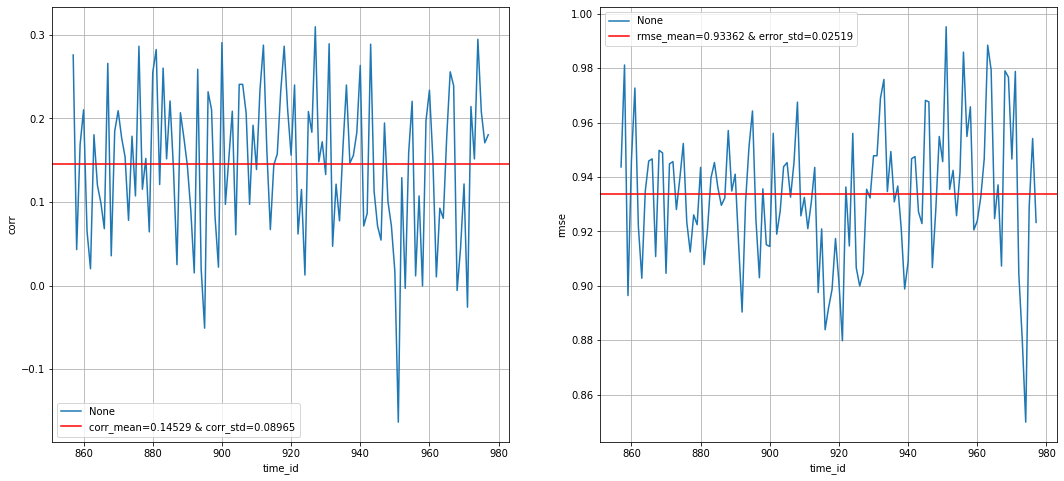

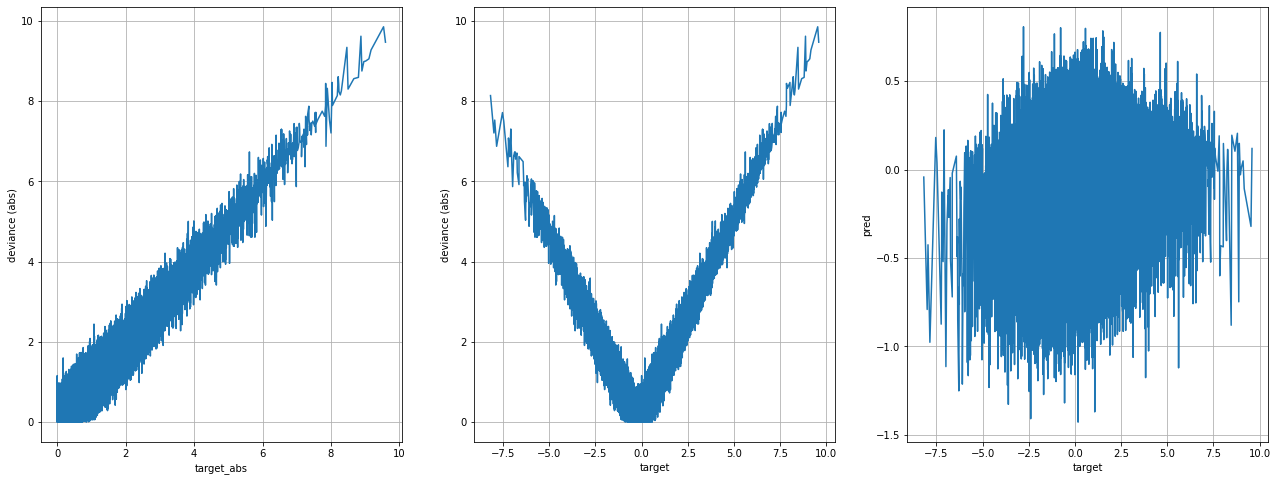

In [10]:
evaluate = True
metrics = {"corr_mean":list(), "corr_std":list(), "error_mean":list(), "error_std":list(),}

if evaluate:
    
    models = list()

    for train_idx,valid_idx in splits:

        train_dset = lgb.Dataset(
            data=features.loc[train_idx,:],
            label=target.loc[train_idx,"target"].values,
            free_raw_data=True
        )
        valid_dset = lgb.Dataset(
            data=features.loc[valid_idx,:],
            label=target.loc[valid_idx,"target"].values,
            free_raw_data=True
        )
        log_callback = lgb.log_evaluation(period=50,)

        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=pearsonr,
            callbacks=[log_callback],
        )
        models.append(model)

        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()
        
        # residual analysis on oof predictions
        oof = target.loc[valid_idx,:].copy()
        oof["time_id"] = time.loc[valid_idx,"time_id"]
        oof["pred"] = model.predict(features.loc[valid_idx,:])
        oof["target_abs"] = oof.eval("abs(target)")
        oof["dev"] = oof.eval("abs(target-pred)")

        corrs = oof.groupby("time_id").apply(lambda x: stats.pearsonr(x.target, x.pred)[0])
        corr_mean = corrs.mean()
        corr_std = corrs.std()
        error = oof.groupby("time_id").apply(lambda x: np.sqrt(np.mean((x.target-x.pred)**2)))
        error_mean = error.mean()
        error_std = error.std()
        
        metrics["corr_mean"].append(corr_mean)
        metrics["corr_std"].append(corr_std)
        metrics["error_mean"].append(error_mean)
        metrics["error_std"].append(error_std)

        plt.figure(figsize=(18,8))
        plt.subplot(1,2,1)
        corrs.plot()
        plt.axhline(
            y=corr_mean, 
            color='r', 
            linestyle='-', 
            label=f"corr_mean={corr_mean:.5f} & corr_std={corr_std:.5f}"
        )
        plt.grid()
        plt.ylabel("corr")
        plt.legend(loc="best")
        ##
        plt.subplot(1,2,2)
        error.plot()
        plt.axhline(
            y=error_mean, 
            color='r', 
            linestyle='-', 
            label=f"rmse_mean={error_mean:.5f} & error_std={error_std:.5f}"
        )
        plt.grid()
        plt.ylabel("rmse")
        plt.legend(loc="best")
        plt.show()

        plt.figure(figsize=(22,8))
        ##
        plt.subplot(1,3,1)
        plt.plot(oof.sort_values("target_abs").target_abs.values, oof.sort_values("target_abs").dev.values)
        plt.xlabel("target_abs")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,2)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").dev.values)
        plt.xlabel("target")
        plt.ylabel("deviance (abs)")
        plt.grid()
        ##
        plt.subplot(1,3,3)
        plt.plot(oof.sort_values("target").target.values, oof.sort_values("target").pred.values)
        plt.xlabel("target")
        plt.ylabel("pred")
        plt.grid()
        plt.show()


In [11]:
metrics

{'corr_mean': [0.14467895412221127, 0.14139479621563175, 0.14529396999551958],
 'corr_std': [0.08295726310756964, 0.07613417233954535, 0.08965020042524696],
 'error_mean': [0.8931233763415073, 0.9003942475698775, 0.9336189227325313],
 'error_std': [0.03666474988297973, 0.03292694863015631, 0.025194010810504885]}

In [12]:
# mean corr on validation
np.mean(metrics["corr_mean"])

0.14378924011112085

In [13]:
# mean rmse on validation
np.mean(metrics["error_mean"])

0.9090455155479721

***
## model training

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	training's rmse: 0.911819	training's pearsonr: 0.161652


[100]	training's rmse: 0.908496	training's pearsonr: 0.180877


[150]	training's rmse: 0.907292	training's pearsonr: 0.190005


[200]	training's rmse: 0.905279	training's pearsonr: 0.201119


[250]	training's rmse: 0.903	training's pearsonr: 0.213929


[300]	training's rmse: 0.901962	training's pearsonr: 0.222296


[350]	training's rmse: 0.899653	training's pearsonr: 0.234359


[400]	training's rmse: 0.898681	training's pearsonr: 0.241774


[450]	training's rmse: 0.897959	training's pearsonr: 0.246129


[500]	training's rmse: 0.897134	training's pearsonr: 0.250738


[550]	training's rmse: 0.896596	training's pearsonr: 0.254843


[600]	training's rmse: 0.895848	training's pearsonr: 0.258906


[650]	training's rmse: 0.895136	training's pearsonr: 0.263011


[700]	training's rmse: 0.894989	training's pearsonr: 0.264859


[750]	training's rmse: 0.894726	training's pearsonr: 0.266875


[800]	training's rmse: 0.893403	training's pearsonr: 0.271508


[850]	training's rmse: 0.892224	training's pearsonr: 0.276922


[900]	training's rmse: 0.891006	training's pearsonr: 0.282697


[950]	training's rmse: 0.890623	training's pearsonr: 0.285475


[1000]	training's rmse: 0.889746	training's pearsonr: 0.289702


[1050]	training's rmse: 0.888961	training's pearsonr: 0.293347


[1100]	training's rmse: 0.887274	training's pearsonr: 0.299984


[1150]	training's rmse: 0.886256	training's pearsonr: 0.305118


[1200]	training's rmse: 0.88555	training's pearsonr: 0.308829


[1250]	training's rmse: 0.884649	training's pearsonr: 0.312623


[1300]	training's rmse: 0.884073	training's pearsonr: 0.315848


[1350]	training's rmse: 0.883116	training's pearsonr: 0.319952


[1400]	training's rmse: 0.882307	training's pearsonr: 0.323701


[1450]	training's rmse: 0.881602	training's pearsonr: 0.327174


[1500]	training's rmse: 0.880883	training's pearsonr: 0.330342


[1550]	training's rmse: 0.880192	training's pearsonr: 0.333461


[1600]	training's rmse: 0.87963	training's pearsonr: 0.336203


[1650]	training's rmse: 0.878858	training's pearsonr: 0.339386


[1700]	training's rmse: 0.878309	training's pearsonr: 0.34222


[1750]	training's rmse: 0.87732	training's pearsonr: 0.345492


[1800]	training's rmse: 0.876311	training's pearsonr: 0.349086


[1850]	training's rmse: 0.8752	training's pearsonr: 0.353274


[1900]	training's rmse: 0.874061	training's pearsonr: 0.357454


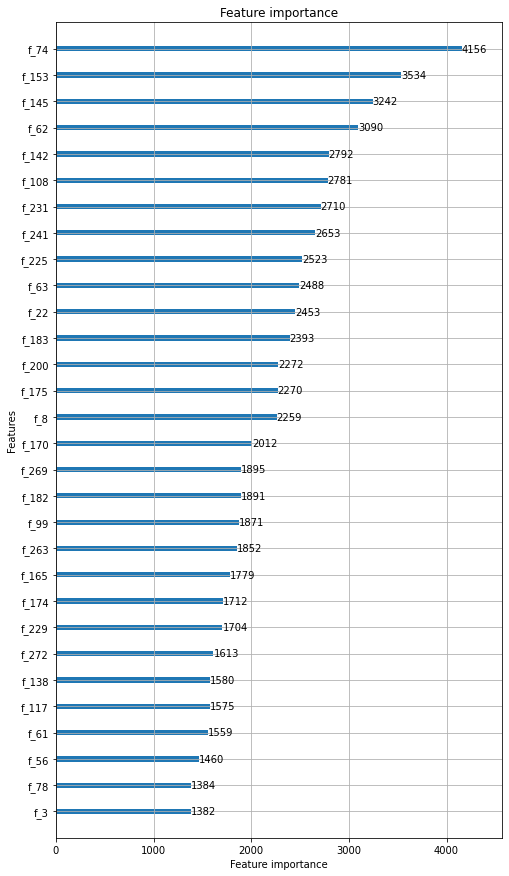

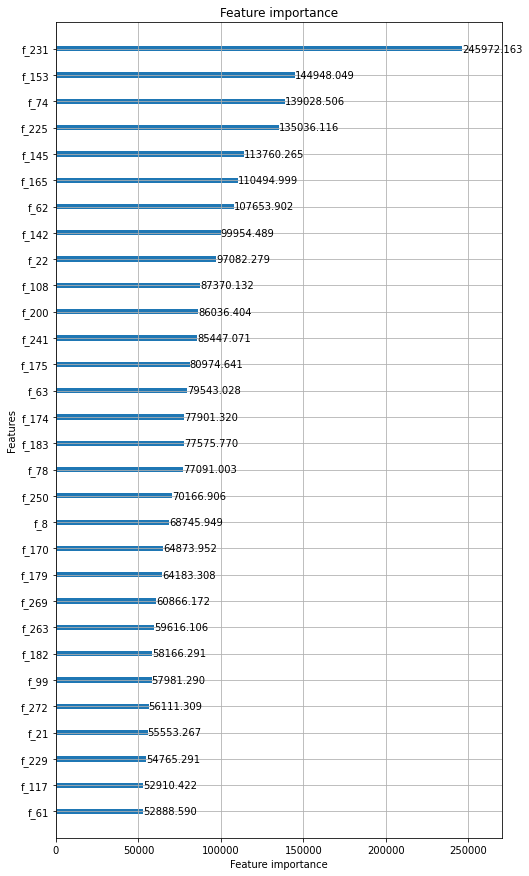

[50]	training's rmse: 0.911405	training's pearsonr: 0.164575


[100]	training's rmse: 0.907457	training's pearsonr: 0.184951


[150]	training's rmse: 0.905276	training's pearsonr: 0.200052


[200]	training's rmse: 0.903029	training's pearsonr: 0.214299


[250]	training's rmse: 0.902089	training's pearsonr: 0.222358


[300]	training's rmse: 0.900428	training's pearsonr: 0.230947


[350]	training's rmse: 0.899381	training's pearsonr: 0.23806


[400]	training's rmse: 0.897803	training's pearsonr: 0.246472


[450]	training's rmse: 0.896864	training's pearsonr: 0.252662


[500]	training's rmse: 0.895491	training's pearsonr: 0.259187


[550]	training's rmse: 0.894357	training's pearsonr: 0.265501


[600]	training's rmse: 0.893098	training's pearsonr: 0.271472


[650]	training's rmse: 0.892414	training's pearsonr: 0.275859


[700]	training's rmse: 0.89133	training's pearsonr: 0.281016


[750]	training's rmse: 0.890605	training's pearsonr: 0.285213


[800]	training's rmse: 0.889561	training's pearsonr: 0.289987


[850]	training's rmse: 0.889338	training's pearsonr: 0.292546


[900]	training's rmse: 0.888426	training's pearsonr: 0.296194


[950]	training's rmse: 0.887327	training's pearsonr: 0.301003


[1000]	training's rmse: 0.886538	training's pearsonr: 0.30485


[1050]	training's rmse: 0.886288	training's pearsonr: 0.307174


[1100]	training's rmse: 0.885675	training's pearsonr: 0.309968


[1150]	training's rmse: 0.885043	training's pearsonr: 0.312615


[1200]	training's rmse: 0.884185	training's pearsonr: 0.31635


[1250]	training's rmse: 0.883401	training's pearsonr: 0.319498


[1300]	training's rmse: 0.882664	training's pearsonr: 0.322856


[1350]	training's rmse: 0.881252	training's pearsonr: 0.327821


[1400]	training's rmse: 0.880406	training's pearsonr: 0.331724


[1450]	training's rmse: 0.879384	training's pearsonr: 0.335927


[1500]	training's rmse: 0.878519	training's pearsonr: 0.339859


[1550]	training's rmse: 0.878057	training's pearsonr: 0.342725


[1600]	training's rmse: 0.877497	training's pearsonr: 0.34524


[1650]	training's rmse: 0.876989	training's pearsonr: 0.348033


[1700]	training's rmse: 0.876107	training's pearsonr: 0.351229


[1750]	training's rmse: 0.875141	training's pearsonr: 0.354649


[1800]	training's rmse: 0.874936	training's pearsonr: 0.356942


[1850]	training's rmse: 0.874382	training's pearsonr: 0.359185


[1900]	training's rmse: 0.873437	training's pearsonr: 0.362551


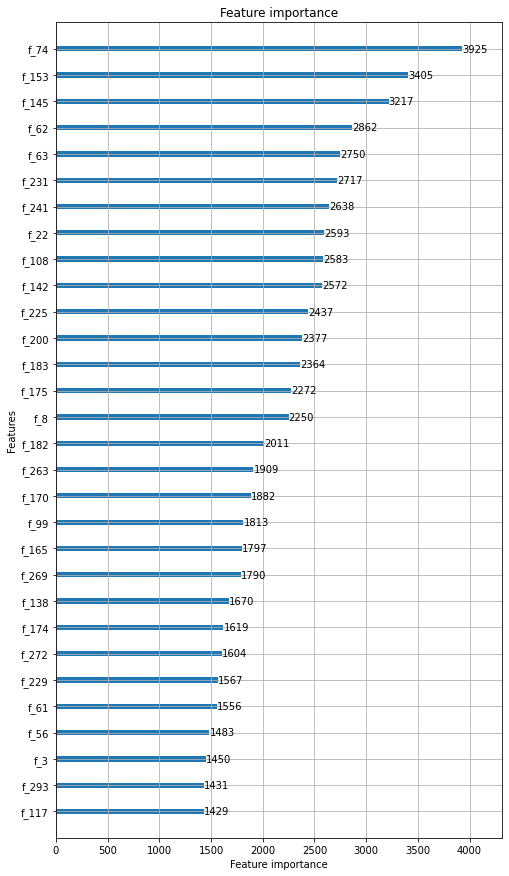

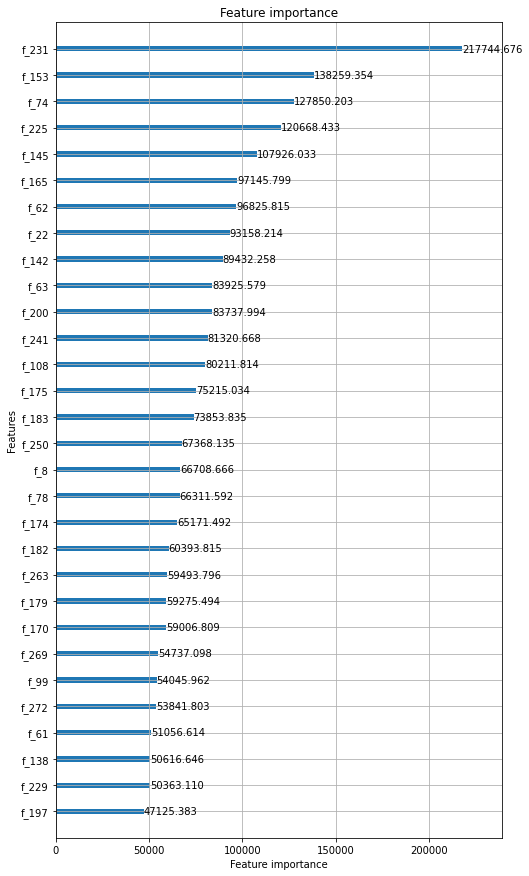

[50]	training's rmse: 0.91221	training's pearsonr: 0.161276


[100]	training's rmse: 0.909754	training's pearsonr: 0.173981


[150]	training's rmse: 0.90742	training's pearsonr: 0.188025


[200]	training's rmse: 0.905605	training's pearsonr: 0.199527


[250]	training's rmse: 0.903715	training's pearsonr: 0.210829


[300]	training's rmse: 0.90279	training's pearsonr: 0.217436


[350]	training's rmse: 0.901963	training's pearsonr: 0.223708


[400]	training's rmse: 0.900998	training's pearsonr: 0.228756


[450]	training's rmse: 0.899619	training's pearsonr: 0.236938


[500]	training's rmse: 0.898062	training's pearsonr: 0.244729


[550]	training's rmse: 0.897271	training's pearsonr: 0.250193


[600]	training's rmse: 0.89556	training's pearsonr: 0.258064


[650]	training's rmse: 0.893742	training's pearsonr: 0.26715


[700]	training's rmse: 0.89187	training's pearsonr: 0.275794


[750]	training's rmse: 0.891038	training's pearsonr: 0.281204


[800]	training's rmse: 0.890278	training's pearsonr: 0.285427


[850]	training's rmse: 0.889767	training's pearsonr: 0.288577


[900]	training's rmse: 0.888964	training's pearsonr: 0.292545


[950]	training's rmse: 0.888422	training's pearsonr: 0.295612


[1000]	training's rmse: 0.887323	training's pearsonr: 0.300358


[1050]	training's rmse: 0.886248	training's pearsonr: 0.305134


[1100]	training's rmse: 0.885173	training's pearsonr: 0.309779


[1150]	training's rmse: 0.884899	training's pearsonr: 0.312516


[1200]	training's rmse: 0.88409	training's pearsonr: 0.315911


[1250]	training's rmse: 0.882914	training's pearsonr: 0.320386


[1300]	training's rmse: 0.882555	training's pearsonr: 0.323253


[1350]	training's rmse: 0.882138	training's pearsonr: 0.325614


[1400]	training's rmse: 0.881713	training's pearsonr: 0.327598


[1450]	training's rmse: 0.881255	training's pearsonr: 0.329914


[1500]	training's rmse: 0.88066	training's pearsonr: 0.332416


[1550]	training's rmse: 0.880112	training's pearsonr: 0.335136


[1600]	training's rmse: 0.879237	training's pearsonr: 0.338045


[1650]	training's rmse: 0.878147	training's pearsonr: 0.342099


[1700]	training's rmse: 0.877205	training's pearsonr: 0.345728


[1750]	training's rmse: 0.876493	training's pearsonr: 0.348945


[1800]	training's rmse: 0.875454	training's pearsonr: 0.352814


[1850]	training's rmse: 0.874348	training's pearsonr: 0.356884


[1900]	training's rmse: 0.874018	training's pearsonr: 0.359118


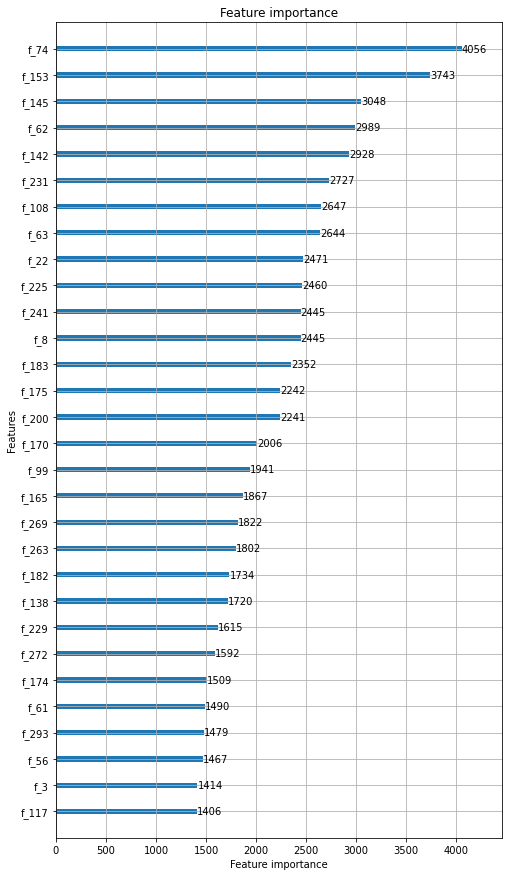

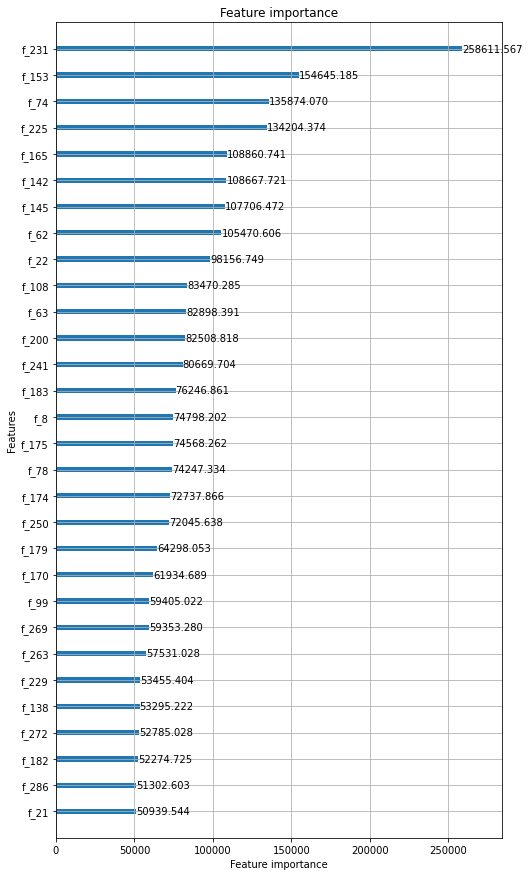

[50]	training's rmse: 0.911774	training's pearsonr: 0.163229


[100]	training's rmse: 0.909749	training's pearsonr: 0.175822


[150]	training's rmse: 0.908031	training's pearsonr: 0.186028


[200]	training's rmse: 0.906259	training's pearsonr: 0.195746


[250]	training's rmse: 0.904211	training's pearsonr: 0.208257


[300]	training's rmse: 0.903294	training's pearsonr: 0.21515


[350]	training's rmse: 0.901742	training's pearsonr: 0.223796


[400]	training's rmse: 0.9008	training's pearsonr: 0.229886


[450]	training's rmse: 0.899732	training's pearsonr: 0.235661


[500]	training's rmse: 0.89843	training's pearsonr: 0.242759


[550]	training's rmse: 0.897506	training's pearsonr: 0.248654


[600]	training's rmse: 0.897132	training's pearsonr: 0.251847


[650]	training's rmse: 0.896826	training's pearsonr: 0.254763


[700]	training's rmse: 0.89523	training's pearsonr: 0.260958


[750]	training's rmse: 0.894022	training's pearsonr: 0.26744


[800]	training's rmse: 0.89311	training's pearsonr: 0.272035


[850]	training's rmse: 0.892659	training's pearsonr: 0.275286


[900]	training's rmse: 0.891995	training's pearsonr: 0.279034


[950]	training's rmse: 0.891791	training's pearsonr: 0.280755


[1000]	training's rmse: 0.890794	training's pearsonr: 0.284742


[1050]	training's rmse: 0.889748	training's pearsonr: 0.289254


[1100]	training's rmse: 0.888925	training's pearsonr: 0.293286


[1150]	training's rmse: 0.887726	training's pearsonr: 0.29827


[1200]	training's rmse: 0.886267	training's pearsonr: 0.304373


[1250]	training's rmse: 0.885565	training's pearsonr: 0.308478


[1300]	training's rmse: 0.884979	training's pearsonr: 0.311722


[1350]	training's rmse: 0.884523	training's pearsonr: 0.314262


[1400]	training's rmse: 0.883642	training's pearsonr: 0.317987


[1450]	training's rmse: 0.882973	training's pearsonr: 0.321426


[1500]	training's rmse: 0.882367	training's pearsonr: 0.324348


[1550]	training's rmse: 0.88181	training's pearsonr: 0.327199


[1600]	training's rmse: 0.881743	training's pearsonr: 0.328749


[1650]	training's rmse: 0.880685	training's pearsonr: 0.332148


[1700]	training's rmse: 0.879573	training's pearsonr: 0.336223


[1750]	training's rmse: 0.878759	training's pearsonr: 0.33953


[1800]	training's rmse: 0.878109	training's pearsonr: 0.342661


[1850]	training's rmse: 0.877384	training's pearsonr: 0.345726


[1900]	training's rmse: 0.87659	training's pearsonr: 0.348904


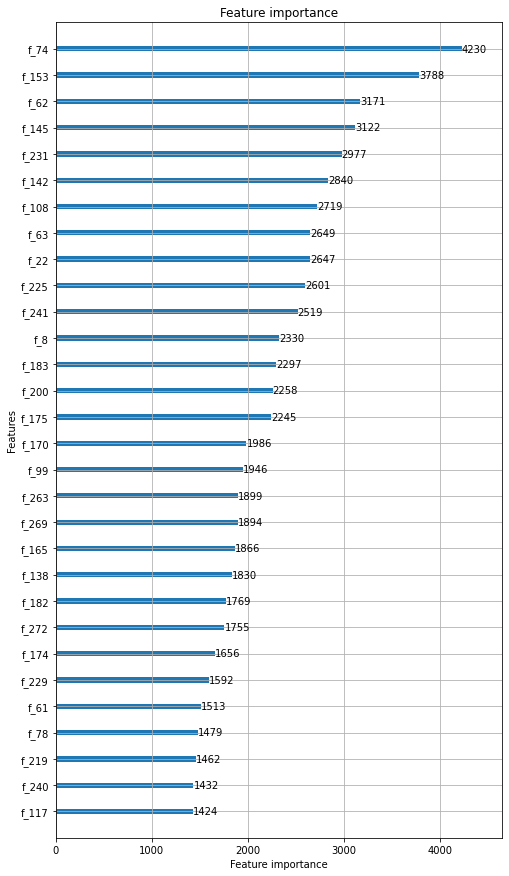

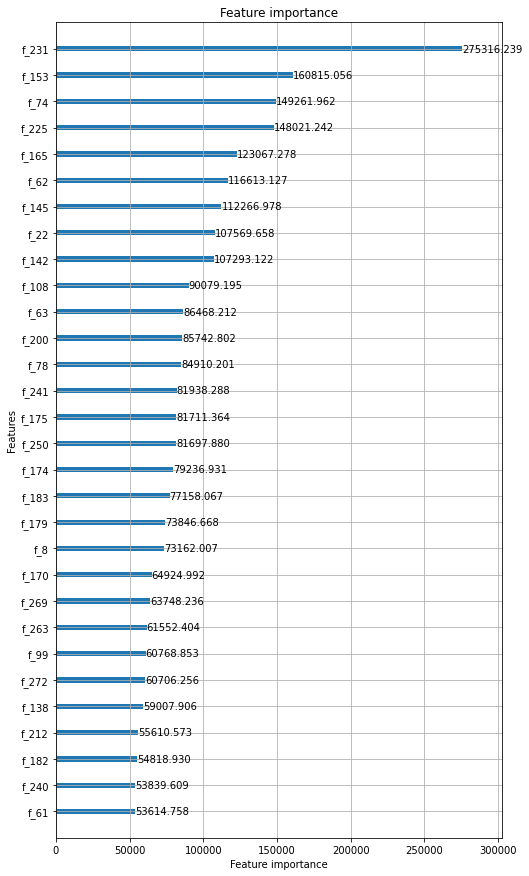

[50]	training's rmse: 0.913353	training's pearsonr: 0.156906


[100]	training's rmse: 0.910107	training's pearsonr: 0.172219


[150]	training's rmse: 0.908007	training's pearsonr: 0.184272


[200]	training's rmse: 0.906222	training's pearsonr: 0.195014


[250]	training's rmse: 0.904295	training's pearsonr: 0.206347


[300]	training's rmse: 0.903429	training's pearsonr: 0.213652


[350]	training's rmse: 0.901546	training's pearsonr: 0.224157


[400]	training's rmse: 0.900905	training's pearsonr: 0.229686


[450]	training's rmse: 0.900097	training's pearsonr: 0.234145


[500]	training's rmse: 0.898957	training's pearsonr: 0.240217


[550]	training's rmse: 0.898131	training's pearsonr: 0.245235


[600]	training's rmse: 0.896603	training's pearsonr: 0.253087


[650]	training's rmse: 0.895795	training's pearsonr: 0.258136


[700]	training's rmse: 0.894413	training's pearsonr: 0.264484


[750]	training's rmse: 0.894335	training's pearsonr: 0.266807


[800]	training's rmse: 0.892861	training's pearsonr: 0.273326


[850]	training's rmse: 0.89236	training's pearsonr: 0.27643


[900]	training's rmse: 0.891453	training's pearsonr: 0.280827


[950]	training's rmse: 0.890218	training's pearsonr: 0.286451


[1000]	training's rmse: 0.888675	training's pearsonr: 0.292682


[1050]	training's rmse: 0.887513	training's pearsonr: 0.298251


[1100]	training's rmse: 0.886803	training's pearsonr: 0.302465


[1150]	training's rmse: 0.885827	training's pearsonr: 0.306923


[1200]	training's rmse: 0.884821	training's pearsonr: 0.31149


[1250]	training's rmse: 0.884022	training's pearsonr: 0.31538


[1300]	training's rmse: 0.883008	training's pearsonr: 0.31978


[1350]	training's rmse: 0.882535	training's pearsonr: 0.322778


[1400]	training's rmse: 0.88142	training's pearsonr: 0.326628


[1450]	training's rmse: 0.881594	training's pearsonr: 0.327996


[1500]	training's rmse: 0.880886	training's pearsonr: 0.330943


[1550]	training's rmse: 0.880256	training's pearsonr: 0.333663


[1600]	training's rmse: 0.879436	training's pearsonr: 0.336808


[1650]	training's rmse: 0.879013	training's pearsonr: 0.339009


[1700]	training's rmse: 0.878126	training's pearsonr: 0.342459


[1750]	training's rmse: 0.877291	training's pearsonr: 0.345689


[1800]	training's rmse: 0.876696	training's pearsonr: 0.348515


[1850]	training's rmse: 0.876236	training's pearsonr: 0.350645


[1900]	training's rmse: 0.875337	training's pearsonr: 0.353705


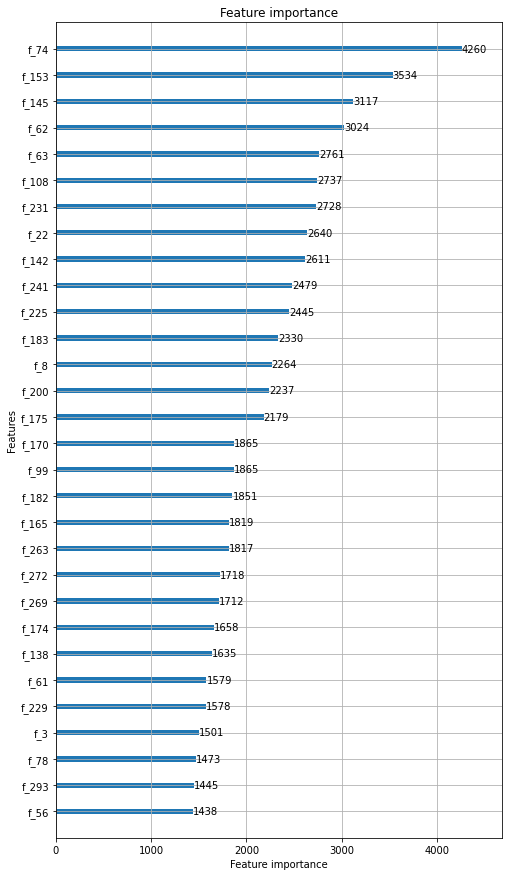

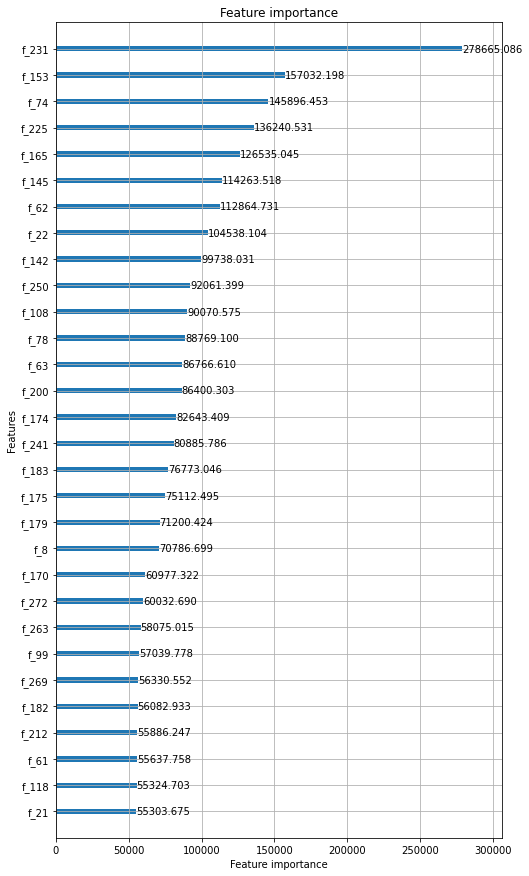

In [14]:
seeds = [
    2, 3, 5, 7, 11, 
    #13, 17, 19, 23, 29, 
    #31, 37, 41, 43, 47, 
    #53, 59, 61, 67, 71, 
    #73, 79, 83, 89, 97,
]
models = list()

for seed in seeds:
    _model_params = dict(model_params)
    _model_params["seed"] = seed
    _model_params["drop_seed"] = seed
    
    train_dset = lgb.Dataset(
        data=features,
        label=target.target.values,
        free_raw_data=True
    )
    model = lgb.train(
        params=_model_params,
        train_set=train_dset,
        valid_sets=[train_dset,],
        feval=pearsonr,
        callbacks=[lgb.log_evaluation(period=50)],
    )
    models.append(model)

    lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
    lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
    plt.show()

In [15]:
for seed,model in zip(seeds,models): 
    model.save_model(f"../ump-artifacts/lgbm-dart/lgbm-seed{seed}.txt")

***
## inference

In [16]:
if current_env == "kaggle":

    import ubiquant
    env = ubiquant.make_env()  
    iter_test = env.iter_test()
    
    features = [f"f_{i}" for i in range(300)]
    for (test_df, sample_prediction_df) in iter_test:  
        preds = [model.predict(test_df[features]) for model in models]
        sample_prediction_df['target'] = np.mean(preds, axis=0)
        env.predict(sample_prediction_df) 
        display(sample_prediction_df)

***